In [31]:
import pandas as pd

import pandas as pd
import numpy as np
import os
from google.colab import drive
drive.mount('/content/drive')
from mlxtend.plotting import heatmap
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
from scipy.stats import randint
from imblearn.over_sampling import RandomOverSampler
import scipy.stats as ss
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns
import plotly.express as px
from tabulate import tabulate


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import ADASYN


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
class MetastaticDiagnosis:
    def __init__(self):
        self.train_df = None
        self.test_df = None

    def read_data(self,train_csv,val_csv,test_csv):
        self.train_df = pd.read_csv(train_csv)
        self.test_df = pd.read_csv(test_csv)
        self.val_df = pd.read_csv(val_csv)
        return self.train_df, self.val_df, self.test_df

    def oversample_data(self):
        if self.train_df is not None:
          X = self.train_df.drop(columns=['DiagPeriodL90D'], axis=1)
          y = self.train_df['DiagPeriodL90D']

          ros = RandomOverSampler(random_state=37)
          X_resampled, y_resampled = ros.fit_resample(X, y)

          self.train_df = pd.concat([X_resampled, y_resampled], axis=1)

          return self.train_df


    def get_column_info(self):
        data_types = self.train_df.dtypes
        categorical_cols = self.train_df.select_dtypes(include=['object', 'category']).columns.tolist()

        numerical_cols = self.train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

        if "patient_zip3" in numerical_cols:
          numerical_cols.remove("patient_zip3")

        if "patient_zip3" not in categorical_cols:
          categorical_cols.append("patient_zip3")
        return categorical_cols, numerical_cols

    def impute_data(self):
      _, numerical_cols = self.get_column_info()
      num_imputer = SimpleImputer(strategy='mean')

      if self.train_df is not None:
        self.train_df[numerical_cols] = num_imputer.fit_transform(self.train_df[numerical_cols])
      if self.val_df is not None:
        self.val_df[numerical_cols] = num_imputer.transform(self.val_df[numerical_cols])

      return self.train_df, self.val_df

    def select_top_features(self, df):
        selected_features = [
        "patient_id", "breast_cancer_diagnosis_code", "patient_age",
        "metastatic_cancer_diagnosis_code", "payer_type", "patient_race",
        "patient_zip3", "patient_state", "income_household_25_to_35",
        "rent_burden", "income_household_under_5","DiagPeriodL90D"
        ]

        return df[selected_features]

    def identify_variable_types(self, dataframe):
        """
        Identifies numerical and categorical variables in the dataframe.

        Parameters:
        - dataframe: A pandas DataFrame.

        Returns:
        - Two lists: one containing numerical variable names and the other containing categorical variable names.
        """
        df_data_types = dataframe.dtypes

        continuous_cols = dataframe.select_dtypes(include=['int64', 'float64']).columns.tolist()

        categorical_cols = dataframe.select_dtypes(include=['object']).columns.tolist()

        if 'patient_zip3' in continuous_cols:
          continuous_cols.remove('patient_zip3')
        if 'patient_zip3' not in categorical_cols:
          categorical_cols.append('patient_zip3')

        return continuous_cols, categorical_cols

    def scale_continuous_features(self, train_df, val_df, continuous_columns, columns_to_exclude):
        columns_to_scale = [col for col in continuous_columns if col not in columns_to_exclude]

        scaler = MinMaxScaler((0, 1)).fit(train_df[columns_to_scale])

        train_df[columns_to_scale] = scaler.transform(train_df[columns_to_scale])
        val_df[columns_to_scale] = scaler.transform(val_df[columns_to_scale])

        return train_df, val_df

    def preprocess_data(self, df, train_columns, categorical_columns):
        df_encoded = pd.get_dummies(df, columns=categorical_columns)

        if train_columns is not None:
            for col in set(train_columns) - set(df_encoded.columns):
                df_encoded[col] = 0

            extra_cols = set(df_encoded.columns) - set(train_columns)
            df_encoded = df_encoded.drop(columns=extra_cols, errors='ignore')

            df_encoded = df_encoded.reindex(columns=train_columns, fill_value=0)

        return df_encoded

    def preprocess_and_shuffle(self, df, target_column, is_fit=False):
        """
        Preprocesses the given dataframe, shuffles the data, and separates the target variable.

        Args:
        df (DataFrame): The DataFrame containing the text data and other features.
        target_column (str): The name of the target column.
        is_fit (bool): If True, fit the preprocessor on the data.

        Returns:
        ndarray: An array of processed and shuffled features.
        Series: The shuffled target variable.
        """
        patient_id = df['patient_id'].values

        features = df.drop(columns=['patient_id', target_column])

        processed_features, target = shuffle(features, df[target_column], random_state=42)

        return processed_features, target, patient_id

train_val_path = '/content/drive/MyDrive/WIDS-Datathon-2024/Hamsini/imputed_values/'
test_path = '/content/drive/MyDrive/WIDS-Datathon-2024/Data/Test/'


meta_obj = MetastaticDiagnosis()

train_csv = train_val_path + 'train_df.csv'
val_csv = train_val_path + 'val_df.csv'
test_csv = test_path + 'test.csv'

train_df, val_df, test_df = meta_obj.read_data(train_csv, val_csv, test_csv)


# Call the oversample_data function
train_df = meta_obj.oversample_data()
print("Train data shape after oversampling columns:", train_df.shape, "\n")

# missing_columns = set(val_df.columns) - set(train_df.columns)
# print("Column(s) missing in train_df:", missing_columns)

print("Train data shape :", train_df.shape, "\n")
print("Val data shape :", val_df.shape, "\n")

print("Test data shape:", test_df.shape, "\n")


train_df, val_df = meta_obj.impute_data()

missing_columns = set(val_df.columns) - set(train_df.columns)
print("Column(s) missing in train_df:", missing_columns)
val_df = val_df.drop(columns='predicted_patient_state')

print("Train data shape after imputation:", train_df.shape)
print("Validation data shape after imputation:", val_df.shape, "\n")

train_df_selected = meta_obj.select_top_features(train_df)
val_df_selected = meta_obj.select_top_features(val_df)
print("Train data shape after feature selection:", train_df_selected.shape)
print("Validation data shape after feature selection:", val_df_selected.shape,"\n")

train_df = train_df.drop('Unnamed: 0', axis=1)
val_df = val_df.drop('Unnamed: 0', axis=1)


continuous_cols, category_cols = meta_obj.identify_variable_types(train_df_selected)
print("Continuous columns:", continuous_cols)
print("Categorical columns:", category_cols,"\n")

continuous_cols_to_exclude = ['patient_id', 'DiagPeriodL90D']
train_df_scaled, val_df_scaled = meta_obj.scale_continuous_features(train_df_selected, val_df_selected, continuous_cols, continuous_cols_to_exclude)
print("After scaling train data ",train_df_scaled.shape)
print("After scaling val data", val_df_scaled.shape, "\n")

train_df_encoded = meta_obj.preprocess_data(train_df_scaled, None, category_cols)

train_columns = train_df_encoded.columns.tolist()

val_df_encoded = meta_obj.preprocess_data(val_df_scaled, train_columns, category_cols)

print("Train data shape after one hot encoding: ", train_df_encoded.shape)
print("Validation data shape after one hot encoding: ", val_df_encoded.shape, "\n")

X_train, y_train, train_patient_id = meta_obj.preprocess_and_shuffle(train_df_encoded, 'DiagPeriodL90D', is_fit=True)

X_val, y_val, val_patient_id = meta_obj.preprocess_and_shuffle(val_df_encoded, 'DiagPeriodL90D', is_fit=False)

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_val shape: ", X_val.shape)
print("y_val shape: ", y_val.shape, "\n")


Train data shape after oversampling columns: (12896, 82) 

Train data shape : (12896, 82) 

Val data shape : (2582, 83) 

Test data shape: (5792, 82) 

Column(s) missing in train_df: {'predicted_patient_state'}
Train data shape after imputation: (12896, 82)
Validation data shape after imputation: (2582, 82) 

Train data shape after feature selection: (12896, 12)
Validation data shape after feature selection: (2582, 12) 

Continuous columns: ['patient_id', 'patient_age', 'income_household_25_to_35', 'rent_burden', 'income_household_under_5', 'DiagPeriodL90D']
Categorical columns: ['breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code', 'payer_type', 'patient_race', 'patient_state', 'patient_zip3'] 



<ipython-input-33-08f763f89ba2>:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[columns_to_scale] = scaler.transform(train_df[columns_to_scale])


After scaling train data  (12896, 12)
After scaling val data (2582, 12) 



<ipython-input-33-08f763f89ba2>:97: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_encoded[col] = 0
<ipython-input-33-08f763f89ba2>:97: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_encoded[col] = 0
<ipython-input-33-08f763f89ba2>:97: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_encoded[col]

Train data shape after one hot encoding:  (12896, 877)
Validation data shape after one hot encoding:  (2582, 877) 

X_train shape:  (12896, 875)
y_train shape:  (12896,)
X_val shape:  (2582, 875)
y_val shape:  (2582,) 



Training Classification Report:
                               precision    recall  f1-score   support

Not Diagnosed within 90 Days       0.93      0.58      0.72      6448
    Diagnosed within 90 Days       0.70      0.96      0.81      6448

                    accuracy                           0.77     12896
                   macro avg       0.81      0.77      0.76     12896
                weighted avg       0.81      0.77      0.76     12896



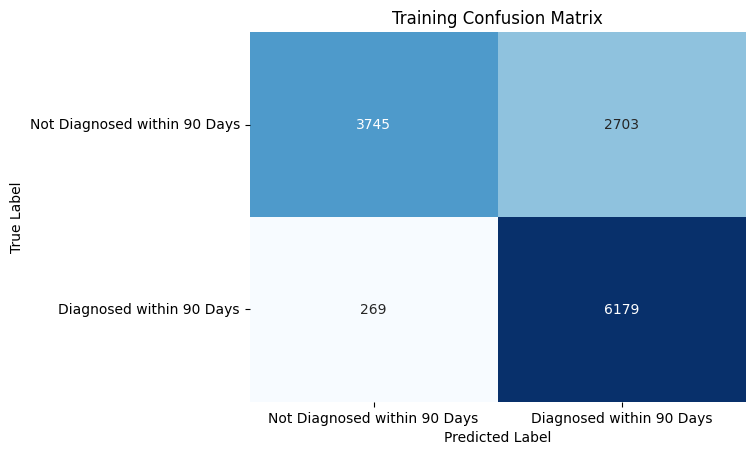

Validation Classification Report:
                               precision    recall  f1-score   support

Not Diagnosed within 90 Days       0.87      0.56      0.68       970
    Diagnosed within 90 Days       0.78      0.95      0.86      1612

                    accuracy                           0.80      2582
                   macro avg       0.82      0.75      0.77      2582
                weighted avg       0.81      0.80      0.79      2582



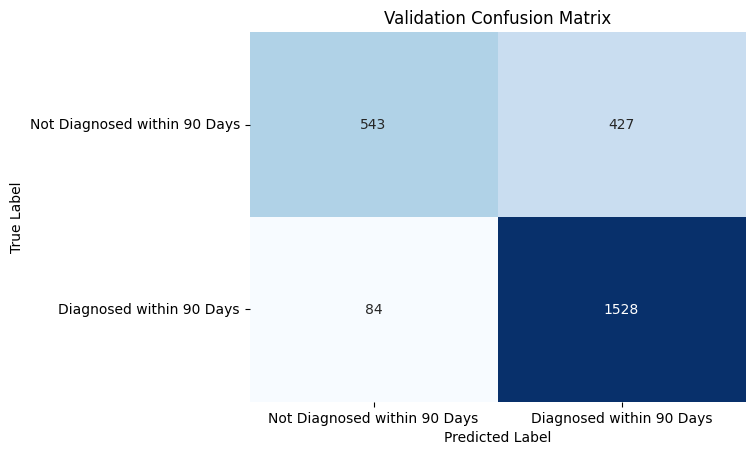


 ROC Curve


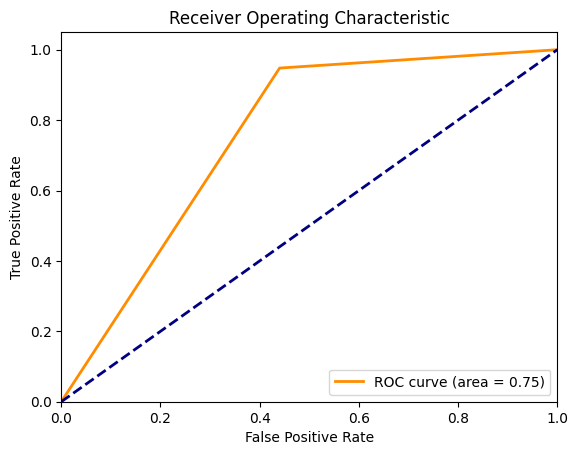

In [34]:

class ModelBuilder:
    def __init__(self):
        self.cf_classifier = None

    def build_random_forest(self):
        # Create a random forest classifier
        rf_classifier = RandomForestClassifier(n_estimators=100,
                                               criterion='gini',
                                               max_depth=20,
                                               min_samples_split=10,
                                               min_samples_leaf=4,
                                               bootstrap=True,
                                               random_state=42)

        self.rf_classifier = rf_classifier

    def train(self, X_train, y_train, category_cols):
        if self.rf_classifier is not None:
            self.rf_classifier.fit(X_train, y_train)
        else:
            raise ValueError("Model has not been built yet.")
        return self.rf_classifier

    def generate_submission(self, X_val, y_val, val_patient_id, original_val_df, result_path):
      if self.rf_classifier is None:
        raise ValueError("Model has not been built yet.")

      val_yhat_probs_sub = self.rf_classifier.predict_proba(X_val)
      val_yhat_probs = self.rf_classifier.predict(X_val)

      original_val_df.reset_index(drop=True, inplace=True)

      submission = pd.DataFrame({
        'patient_id': val_patient_id,
        'DiagPeriodL90D_actual': y_val,
        'prediction': val_yhat_probs,
        'prediction_probability': val_yhat_probs_sub[:, 1],
        'breast_cancer_diagnosis_code': original_val_df['breast_cancer_diagnosis_code'],
        'patient_age': original_val_df['patient_age'],
        'metastatic_cancer_diagnosis_code': original_val_df['metastatic_cancer_diagnosis_code'],
        'patient_race': original_val_df['patient_race'],
        'patient_zip3': original_val_df['patient_zip3'],
        'patient_state': original_val_df['patient_state'],
        'payer_type': original_val_df['payer_type'],
        'income_household_25_to_35': original_val_df['income_household_25_to_35'],
        'rent_burden': original_val_df['rent_burden'],
        'income_household_under_5': original_val_df['income_household_under_5']
      })

      submission.to_csv(result_path + 'RF_feb_20.csv', index=False)

      errors_only = submission[submission['DiagPeriodL90D_actual'] != submission['prediction']]

      # Save the errors-only submission file
      errors_only.to_csv(result_path + 'RF_feb_20_errors.csv', index=False)

      return submission, errors_only


    def calculate_training_classification_report(self, y_train, train_yhat_probs,classes):
        report = classification_report(y_train, train_yhat_probs, target_names=classes)
        return report

    def plot_training_confusion_matrix(self, y_train, train_yhat_probs, classes):
        train_cm = confusion_matrix(y_train, train_yhat_probs)
        ax = sns.heatmap(train_cm,
                         annot=True,
                         fmt='.0f',
                         cmap='Blues',
                         xticklabels=classes,
                         yticklabels=classes,
                         cbar=False)
        ax.set(xlabel='Predicted Label', ylabel='True Label')
        plt.title('Training Confusion Matrix')
        plt.show()

    def calculate_validation_classification_report(self, y_val, val_yhat_probs, classes):
        report = classification_report(y_val, val_yhat_probs, target_names=classes)
        return report

    def plot_validation_confusion_matrix(self, y_val, val_yhat_probs, classes):
        val_cm = confusion_matrix(y_val, val_yhat_probs)
        ax = sns.heatmap(val_cm,
                         annot=True,
                         fmt='.0f',
                         cmap='Blues',
                         xticklabels=classes,
                         yticklabels=classes,
                         cbar=False)
        ax.set(xlabel='Predicted Label', ylabel='True Label')
        plt.title('Validation Confusion Matrix')
        plt.show()

    def plot_roc_curve(self, y_true, y_scores):
      """
      Plot the Receiver Operating Characteristic (ROC) curve.

      Args:
      y_true (array-like): True binary labels.
      y_scores (array-like): Target scores, can either be probability estimates of the positive class or confidence values.

      Returns:
      None (displays the ROC curve plot).
      """
      fpr, tpr, _ = roc_curve(y_true, y_scores)
      roc_auc = auc(fpr, tpr)

      plt.figure()
      plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
      plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title('Receiver Operating Characteristic')
      plt.legend(loc="lower right")
      plt.show()



model_trainer = ModelBuilder()

model_trainer.build_random_forest()

rf_classifier = model_trainer.train(X_train, y_train, category_cols)

result_path = '/content/drive/MyDrive/HS/prediction/'
model_trainer.generate_submission(X_val, y_val, val_patient_id, val_df_selected, result_path)


train_yhat_probs = rf_classifier.predict(X_train)
val_yhat_probs = rf_classifier.predict(X_val)

classes = ["Not Diagnosed within 90 Days", "Diagnosed within 90 Days"]


train_classification_report = model_trainer.calculate_training_classification_report(y_train, train_yhat_probs,classes)
print("Training Classification Report:\n", train_classification_report)

model_trainer.plot_training_confusion_matrix(y_train, train_yhat_probs,classes)


val_classification_report = model_trainer.calculate_validation_classification_report(y_val, val_yhat_probs,classes)
print("Validation Classification Report:\n", val_classification_report)

model_trainer.plot_validation_confusion_matrix(y_val, val_yhat_probs,classes)

print("\n ROC Curve")
y_true = y_val
y_scores = val_yhat_probs
model_trainer.plot_roc_curve(y_true, y_scores)